# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

Distinguishing between "ae" and "ux" should be pretty straightforward. Adding "ey" into the mix we can see that it has strong overlap with both "ae" and "ux". Though, judging from the plot the overlap between "ey" and "ux" is worse. This is partly due to "ae" having a more clear clustering with some outliers compared to "ux".

<IPython.core.display.Javascript object>


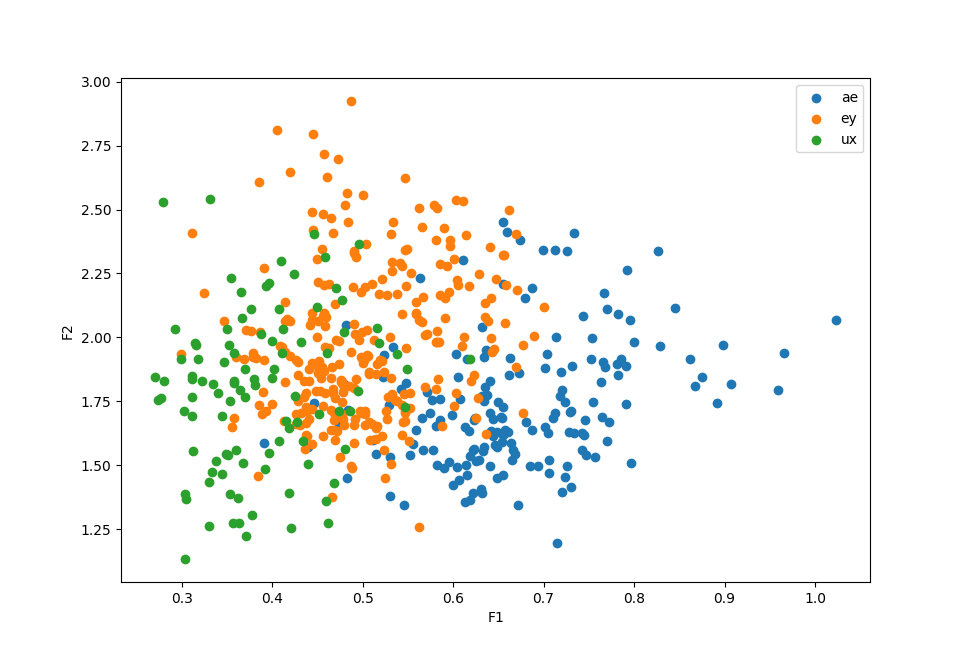

In [108]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib notebook

logging.basicConfig(level=logging.INFO)

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']

# Colorlist
colors = [
    mcolors.TABLEAU_COLORS['tab:blue'],
    mcolors.TABLEAU_COLORS['tab:orange'],
    mcolors.TABLEAU_COLORS['tab:green'],
    mcolors.TABLEAU_COLORS['tab:cyan'],
    mcolors.TABLEAU_COLORS['tab:red'],
    mcolors.TABLEAU_COLORS['tab:olive'],
    mcolors.TABLEAU_COLORS['tab:purple'],
    mcolors.TABLEAU_COLORS['tab:gray'],
]

# Plotting here
def plot_scatter(
    data,
    ax,
    phonemes=["ae","ey","ux"],
    columns=["F1","F2"],
    label=True,
):
    for i, phoneme in enumerate(phonemes):
        temp = data[data["Phoneme"]==phoneme]
        label_ = phoneme if label else None
        plt.scatter(x=temp[columns[0]],y=temp[columns[1]],label=label_,c=colors[i])
    plt.xlabel(columns[0])
    plt.ylabel(columns[1])
    plt.legend()

fig, ax = plt.subplots(1,1)
plot_scatter(data=train,ax=ax)

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

In [35]:
def extract_phonemes(data,phonemes=["ae","ey","ux"]):
    return data[data["Phoneme"].isin(phonemes)]

def generate_feature_vector(data,phoneme,columns=["F1","F2"]):
    return data[data["Phoneme"]==phoneme].filter(columns)

def pre_processing(data,phoneme,columns=["F1","F2"]):
    feature_vector = generate_feature_vector(
        data=data,
        phoneme=phoneme,
        columns=columns,
    )
    return {
        'feature_vector': feature_vector,
        'mean': feature_vector.mean(),
        'cov': feature_vector.cov(),
        'prior': len(feature_vector)/len(data),
    }

# Extract phonemes of interest
training_data = extract_phonemes(train)
test_data = extract_phonemes(test)

# Generate values of interest
aes_processed = pre_processing(training_data,"ae")
eys_processed = pre_processing(training_data,"ey")
uxs_processed = pre_processing(training_data,"ux")

(c) To visualize the classes models and the classifier created in (b), plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$, by using the following function.

In [4]:
import scipy.stats

def plotGaussian(mean, cov, color, ax):
    """ 
        Creates a contour plot for a bi-variate normal distribution
        
        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = scipy.stats.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    ax.contour(x,y,lik,colors=color)

<IPython.core.display.Javascript object>


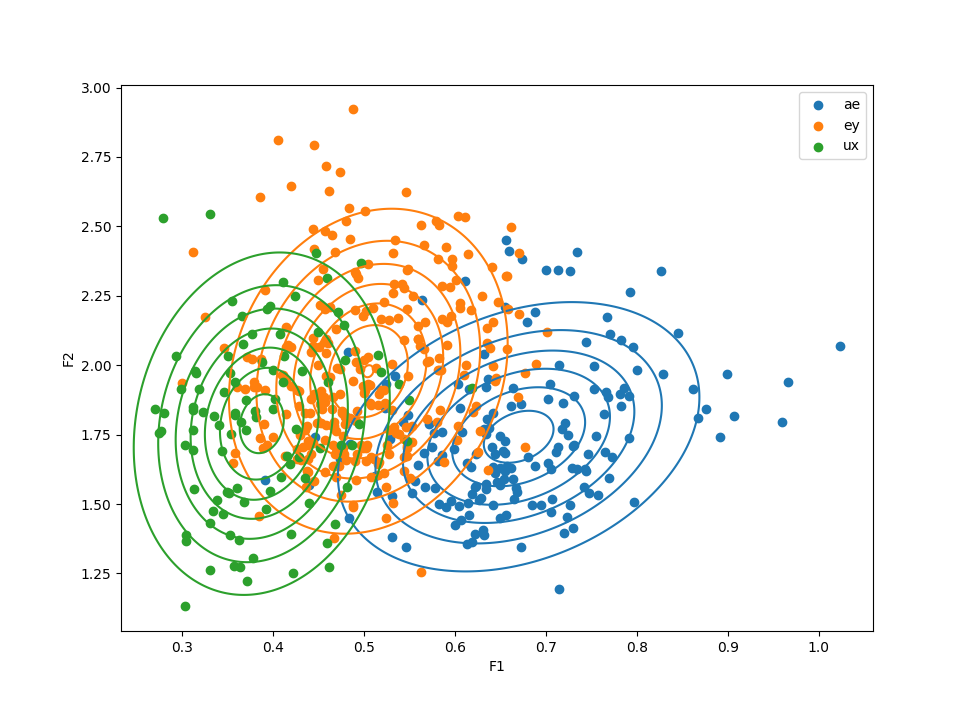

In [109]:
# Generate plot
fig, ax = plt.subplots(1,1)
plot_scatter(data=train,ax=ax)

plotGaussian(aes_processed['mean'],aes_processed['cov'],colors[0],ax)
plotGaussian(eys_processed['mean'],eys_processed['cov'],colors[1],ax)
plotGaussian(uxs_processed['mean'],uxs_processed['cov'],colors[2],ax)

*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

<IPython.core.display.Javascript object>


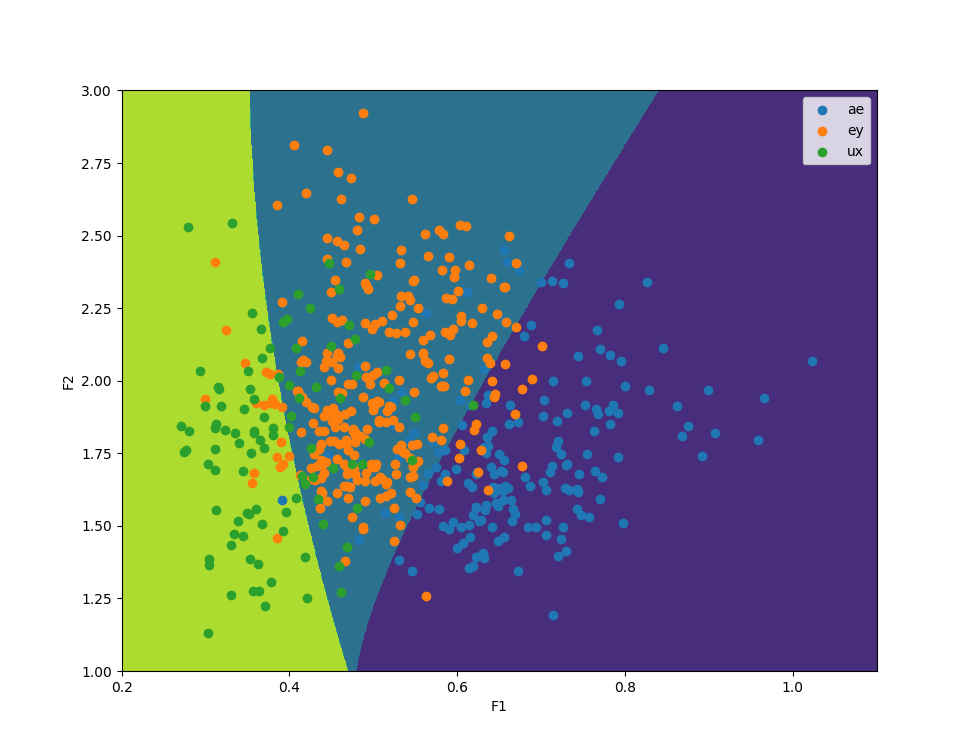

In [110]:
# Generate Models
class BayesianModel:
    def __init__(self,mean,cov,prior,class_name):
        self.mean = mean
        self.cov = cov
        self.prior = prior
        self.class_name = class_name
        self.model = scipy.stats.multivariate_normal(self.mean, self.cov)
    
    def posterior(self,f):
        return self.model.pdf(f)*self.prior

aes_model = BayesianModel(aes_processed['mean'],aes_processed['cov'],aes_processed['prior'],"ae")
eys_model = BayesianModel(eys_processed['mean'],eys_processed['cov'],eys_processed['prior'],"ey")
uxs_model = BayesianModel(uxs_processed['mean'],uxs_processed['cov'],uxs_processed['prior'],"ux")

# Generate Classifier
class Classifier:
    def __init__(self,models):
        self.models = models
    
    @property
    def mapping(self):
        return [model.class_name() for model in self.models]
    
    def classify(self,x):
        return np.argmax(np.dstack([model.posterior(x) for model in self.models]),axis=2)

f1_f2_classifier = Classifier(models=[aes_model,eys_model,uxs_model])

# Mapping from int to phoneme class
height_levels = {'ae':0,'ey':1,'ux':2,0:'ae',1:'ey',2:'ux'}

# Generate Plot
fig, ax = plt.subplots(1,1)
number_of_evals=1000
f1_mesh, f2_mesh = np.meshgrid(
    np.linspace(start=0.2,stop=1.1,num=number_of_evals),
    np.linspace(start=1.0,stop=3.0,num=number_of_evals),
)
z = f1_f2_classifier.classify(np.dstack((f1_mesh,f2_mesh)))

ax.contourf(f1_mesh,f2_mesh,z,levels=3)
plot_scatter(data=train,ax=ax)

(d) Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

<IPython.core.display.Javascript object>


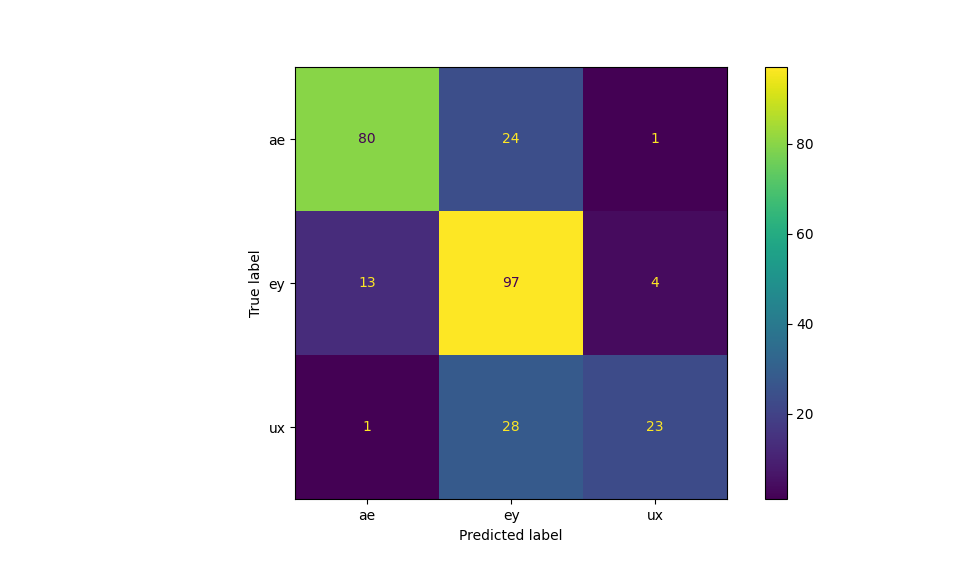

In [111]:
import sklearn.metrics as skm

def generate_confusion_matrix(training_data,test_data,columns):
    # Generate data
    aes_processed = pre_processing(
        data=training_data,
        phoneme="ae",
        columns=columns,
    )
    eys_processed = pre_processing(
        data=training_data,
        phoneme="ey",
        columns=columns,
    )
    uxs_processed = pre_processing(
        data=training_data,
        phoneme="ux",
        columns=columns,
    )

    # Generate models
    aes_model = BayesianModel(aes_processed['mean'],aes_processed['cov'],aes_processed['prior'],"ae")
    eys_model = BayesianModel(eys_processed['mean'],eys_processed['cov'],eys_processed['prior'],"ey")
    uxs_model = BayesianModel(uxs_processed['mean'],uxs_processed['cov'],uxs_processed['prior'],"ux")

    # Generate classifier
    f1_f2_classifier = Classifier(models=[aes_model,eys_model,uxs_model])

    # Generate confusion matrix
    test = test_data[columns].to_numpy()

    actual = np.vectorize(height_levels.get)(test_data.filter(['Phoneme']).to_numpy())
    estimation = f1_f2_classifier.classify(test)

    conf_mat = skm.confusion_matrix(actual,estimation.transpose())
    disp = skm.ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=[height_levels[0],height_levels[1],height_levels[2]],
    )
    disp.plot()

generate_confusion_matrix(
    training_data=training_data,
    test_data=test_data,
    columns=["F1","F2"],
)

(e) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (d). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

<IPython.core.display.Javascript object>


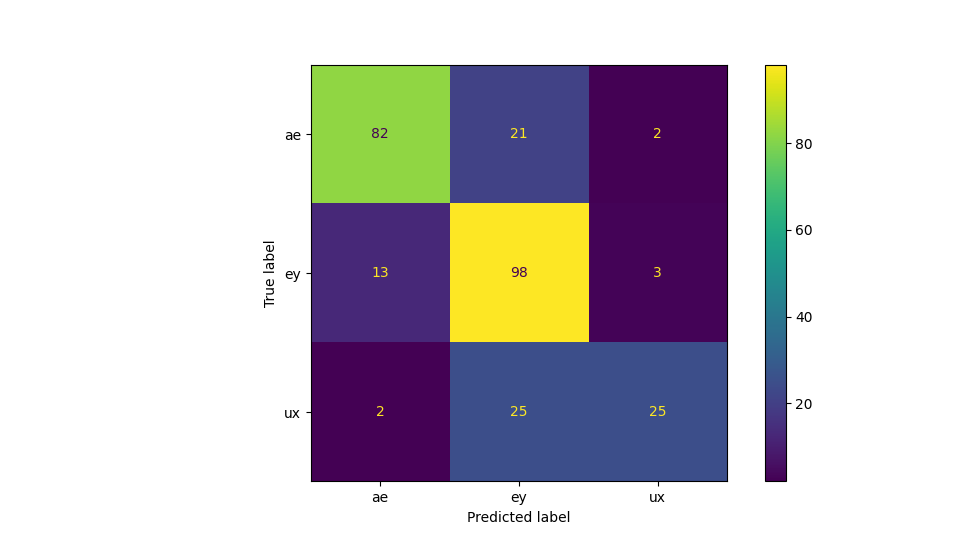

In [112]:
generate_confusion_matrix(
    training_data=training_data,
    test_data=test_data,
    columns=["F1","F2","F3","F4"],
)

<IPython.core.display.Javascript object>


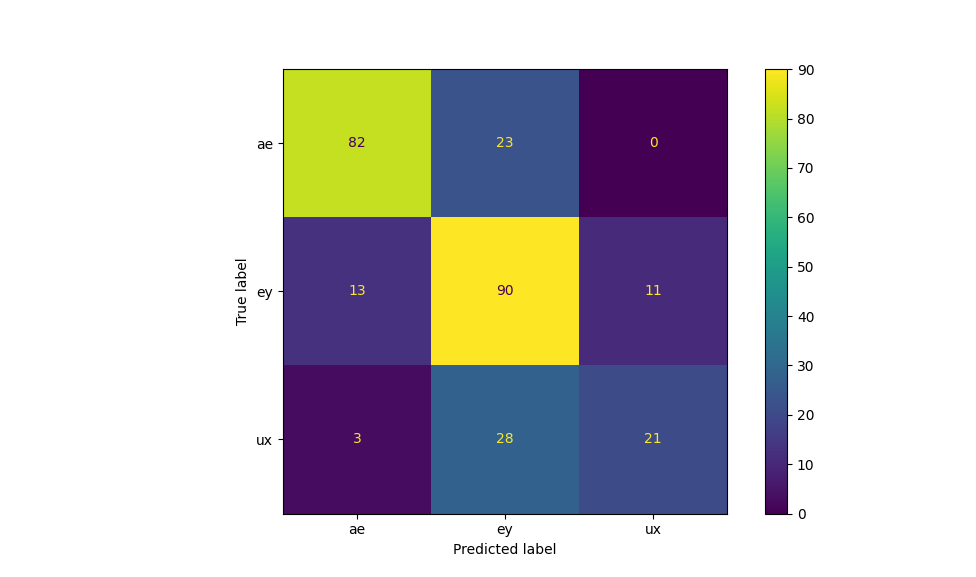

In [113]:
generate_confusion_matrix(
    training_data=training_data,
    test_data=test_data,
    columns=["F1","F2","F3","F4","B1","B2","B3","B4"],
)

(f) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (e).

We split the phoneme's data for the gender and use gaussian model for male and female seperately, as shown in figure 8.
Then we do the usual and use the maximum posterior to decide the classes' prediction.

<IPython.core.display.Javascript object>


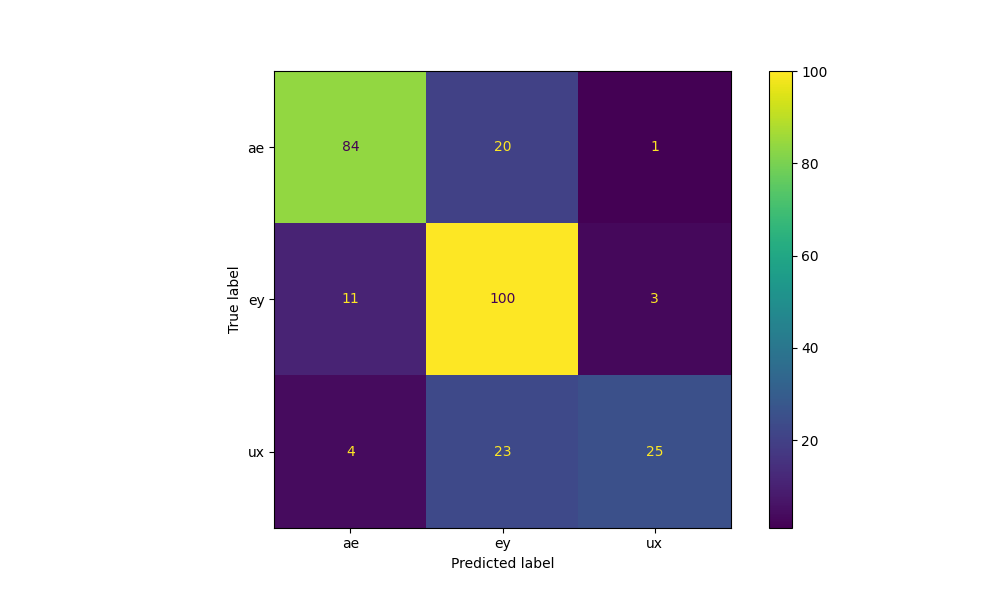

In [114]:
# Generate Feature Vectors
def generate_feature_vector_gender(data,phoneme,gender,columns=["F1","F2","F3","F4"]):
    phoneme_filtered = data[data["Phoneme"]==phoneme]
    gender_filtered =  phoneme_filtered[phoneme_filtered["Gender"]==gender]
    return gender_filtered.filter(columns)


def pre_processing_gender(data,phoneme,gender,columns=["F1","F2","F3","F4"]):
    feature_vector = generate_feature_vector_gender(
        data=data,
        phoneme=phoneme,
        gender=gender,
        columns=columns,
    )
    return {
        'feature_vector': feature_vector,
        'mean': feature_vector.mean(),
        'cov': feature_vector.cov(),
        'prior': len(feature_vector)/len(data),
    }

columns = ["F1","F2","F3","F4"]

# Preprocess Data
ae_f= pre_processing_gender(data=train,phoneme="ae",gender="F",columns=columns)
ae_m= pre_processing_gender(data=train,phoneme="ae",gender="M",columns=columns)
ey_f= pre_processing_gender(data=train,phoneme="ey",gender="F",columns=columns)
ey_m= pre_processing_gender(data=train,phoneme="ey",gender="M",columns=columns)
ux_f= pre_processing_gender(data=train,phoneme="ux",gender="F",columns=columns)
ux_m= pre_processing_gender(data=train,phoneme="ux",gender="M",columns=columns)

# Generate Models
ae_f_model = BayesianModel(ae_f['mean'],ae_f['cov'],ae_f['prior'],"ae")
ae_m_model = BayesianModel(ae_m['mean'],ae_m['cov'],ae_m['prior'],"ae")
ey_f_model = BayesianModel(ey_f['mean'],ey_f['cov'],ey_f['prior'],"ey")
ey_m_model = BayesianModel(ey_m['mean'],ey_m['cov'],ey_m['prior'],"ey")
ux_f_model = BayesianModel(ux_f['mean'],ux_f['cov'],ux_f['prior'],"ux")
ux_m_model = BayesianModel(ux_m['mean'],ux_m['cov'],ux_m['prior'],"ux")

phoneme_gender_classifier = Classifier(
    models=[
        ae_f_model,
        ae_m_model,
        ey_f_model,
        ey_m_model,
        ux_f_model,
        ux_m_model,
    ],
)

# Generate confusion matrix
test = test_data[columns].to_numpy()

actual = np.vectorize(height_levels.get)(test_data.filter(['Phoneme']).to_numpy())
estimation = phoneme_gender_classifier.classify(test)//2

conf_mat = skm.confusion_matrix(actual,estimation.transpose())
disp = skm.ConfusionMatrixDisplay(
    confusion_matrix=conf_mat,
    display_labels=[height_levels[0],height_levels[1],height_levels[2]],
)
disp.plot()

<IPython.core.display.Javascript object>


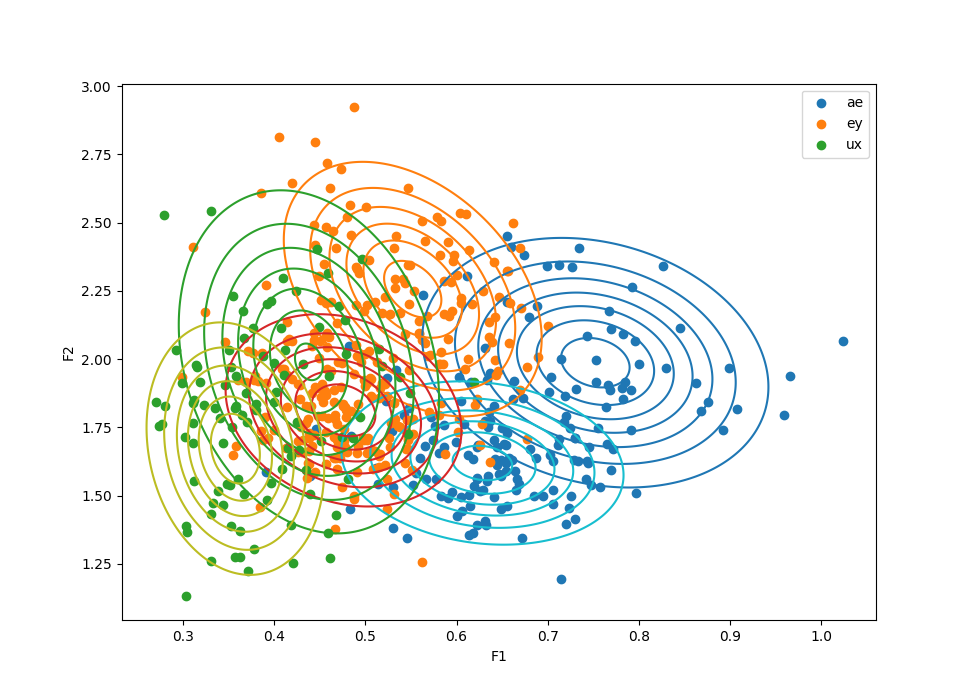

In [115]:
ae_f_2 = pre_processing_gender(data=train,phoneme="ae",gender="F",columns=["F1","F2"])
ae_m_2 = pre_processing_gender(data=train,phoneme="ae",gender="M",columns=["F1","F2"])
ey_f_2 = pre_processing_gender(data=train,phoneme="ey",gender="F",columns=["F1","F2"])
ey_m_2 = pre_processing_gender(data=train,phoneme="ey",gender="M",columns=["F1","F2"])
ux_f_2 = pre_processing_gender(data=train,phoneme="ux",gender="F",columns=["F1","F2"])
ux_m_2 = pre_processing_gender(data=train,phoneme="ux",gender="M",columns=["F1","F2"])

# Generate plot
fig, ax = plt.subplots(1,1)
plot_scatter(data=train,ax=ax)

plotGaussian(ae_f_2['mean'],ae_f_2['cov'],colors[0],ax)
plotGaussian(ae_m_2['mean'],ae_m_2['cov'],colors[3],ax)
plotGaussian(ey_f_2['mean'],ey_f_2['cov'],colors[1],ax)
plotGaussian(ey_m_2['mean'],ey_m_2['cov'],colors[4],ax)
plotGaussian(ux_f_2['mean'],ux_f_2['cov'],colors[2],ax)
plotGaussian(ux_m_2['mean'],ux_m_2['cov'],colors[5],ax)

(g) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (f) using only diagonal covariance matrices and compare the results.

<IPython.core.display.Javascript object>


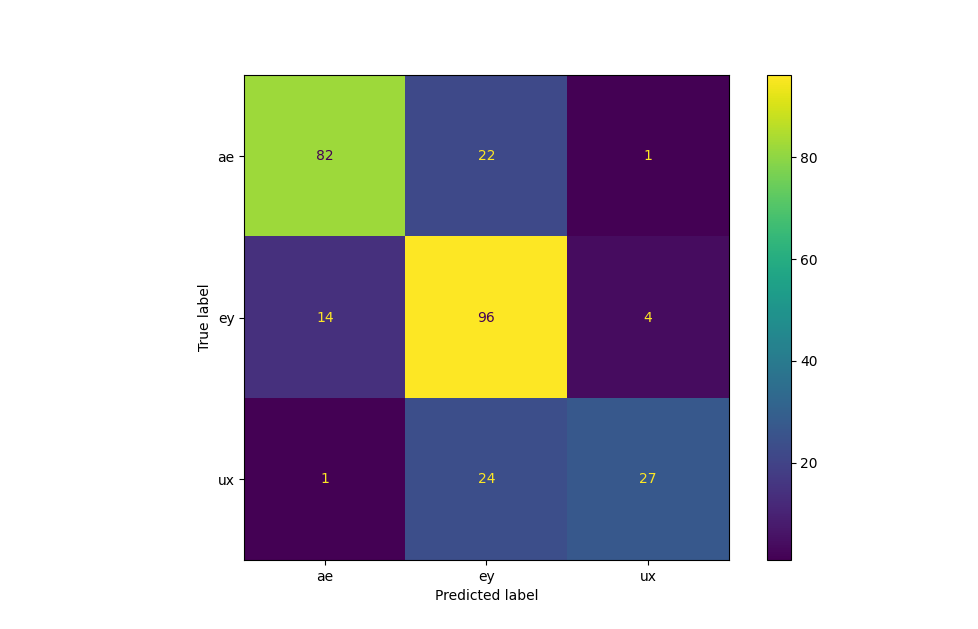

In [116]:
# Generate Models
ae_f_model = BayesianModel(ae_f['mean'],np.diag(np.diag(ae_f['cov'])),ae_f['prior'],"ae")
ae_m_model = BayesianModel(ae_m['mean'],np.diag(np.diag(ae_m['cov'])),ae_m['prior'],"ae")
ey_f_model = BayesianModel(ey_f['mean'],np.diag(np.diag(ey_f['cov'])),ey_f['prior'],"ey")
ey_m_model = BayesianModel(ey_m['mean'],np.diag(np.diag(ey_m['cov'])),ey_m['prior'],"ey")
ux_f_model = BayesianModel(ux_f['mean'],np.diag(np.diag(ux_f['cov'])),ux_f['prior'],"ux")
ux_m_model = BayesianModel(ux_m['mean'],np.diag(np.diag(ux_m['cov'])),ux_m['prior'],"ux")

phoneme_gender_classifier = Classifier(
    models=[
        ae_f_model,
        ae_m_model,
        ey_f_model,
        ey_m_model,
        ux_f_model,
        ux_m_model,
    ],
)

# Generate confusion matrix
test = test_data[columns].to_numpy()

actual = np.vectorize(height_levels.get)(test_data.filter(['Phoneme']).to_numpy())
estimation = phoneme_gender_classifier.classify(test)//2

conf_mat = skm.confusion_matrix(actual,estimation.transpose())
disp = skm.ConfusionMatrixDisplay(
    confusion_matrix=conf_mat,
    display_labels=[height_levels[0],height_levels[1],height_levels[2]],
)
disp.plot()

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [102]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

def plot_svm_decision_regions(clf,data,ax,columns=["F1","F2"]):
    '''
    This function is for plotting the decision area of SVM
    
    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    phonemes = np.array(["ae","ey","ux"])
    x_min, x_max = data["F1"].min() - 0.2, data["F1"].max() + 0.2
    y_min, y_max = data["F2"].min() - 0.2, data["F2"].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plot_scatter(data=data,phonemes=phonemes,columns=columns,ax=ax)
    ax.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    ax.legend()

def plot_support_vectors(clf,data,ax):
    '''
    This function is for plotting the support vectors of the SVM model
    
    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data["F1"].min() - 0.2, data["F1"].max() + 0.2
    y_min, y_max = data["F2"].min() - 0.2, data["F2"].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Plotting
    ax.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    ax.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    ax.legend()
    

In [75]:
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm

# Pre-Processing
columns = ["F1","F2"]

train_svc = train[train["Phoneme"].isin(["ae","ey","ux"])]
test_svc = test[test["Phoneme"].isin(["ae","ey","ux"])]
feature_vectors = train_svc.loc[:, columns].to_numpy()
test_vectors = test_svc.loc[:, columns].to_numpy()
y = np.vectorize(height_levels.get)(train_svc.filter(['Phoneme']).to_numpy())
y = np.reshape(y, (len(y),))
y_test_actual = np.vectorize(height_levels.get)(test_svc.filter(['Phoneme']).to_numpy())
y_test_actual = np.reshape(y_test_actual, (len(y_test_actual),))

logging.info(f"Shape X: {feature_vectors.shape}")
logging.info(f"Shape Y: {np.shape(y)}")

INFO:root:Shape X: (556, 2)
INFO:root:Shape Y: (556,)


(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

<IPython.core.display.Javascript object>


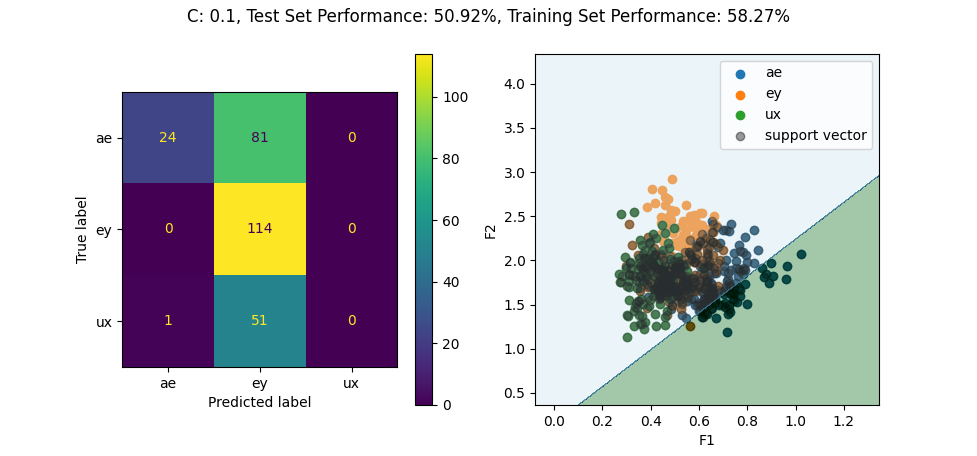

<IPython.core.display.Javascript object>


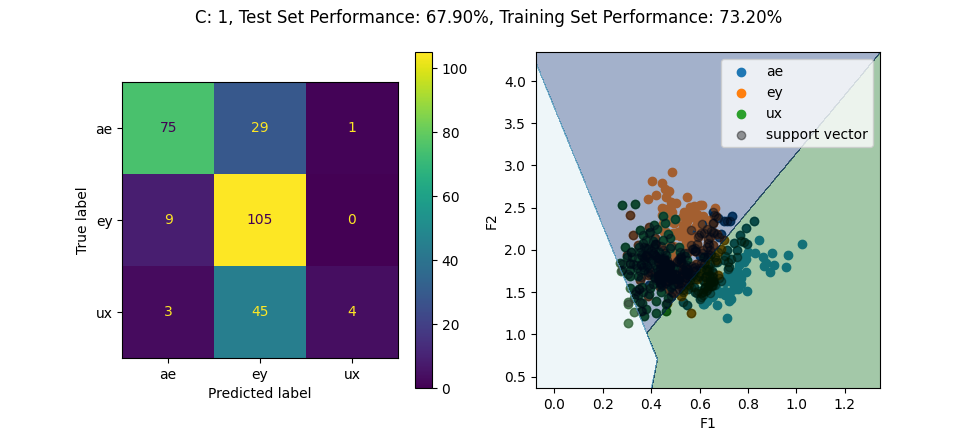

<IPython.core.display.Javascript object>


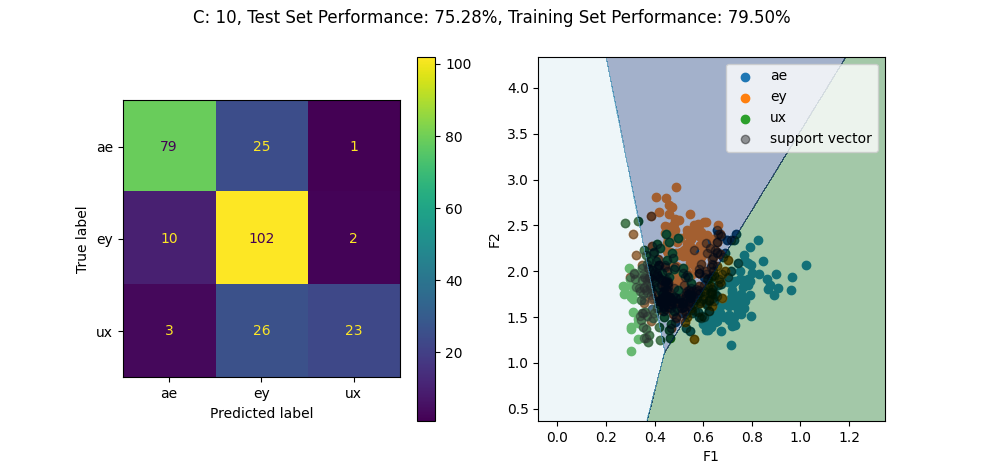

In [124]:
# Fitting
cs = [0.1,1,10]
clfs = [sklearn.svm.SVC(kernel='linear',C=c) for c in cs]
for clf in clfs:
    clf.fit(feature_vectors,y)

# Prediction
y_test_predictions = [clf.predict(test_vectors) for clf in clfs]
y_train_predictions = [clf.predict(feature_vectors) for clf in clfs]

test_performance = [100*sum(y_pred==y_test_actual)/len(y_pred) for y_pred in y_test_predictions]
train_performance = [100*sum(y_pred==y)/len(y_pred) for y_pred in y_train_predictions]

# Plot
conf_mats = [skm.confusion_matrix(y_test_actual,y_test_predict) for y_test_predict in y_test_predictions]

for index, conf_mat in enumerate(conf_mats):
    fig, axs = plt.subplots(1,2)
    fig.suptitle(
        "C: {cs_f}, Test Set Performance: {test_f:.2f}%, Training Set Performance: {train_f:.2f}%".format(
            cs_f=cs[index],
            test_f=test_performance[index],
            train_f=train_performance[index],
        )
    )
    disp = skm.ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=[height_levels[0],height_levels[1],height_levels[2]],
    )
    disp.plot(ax=axs[0])
    plot_svm_decision_regions(clf=clfs[index],data=train,columns=columns,ax=axs[1])
    plot_support_vectors(clf=clfs[index],data=train,ax=axs[1])

(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

<IPython.core.display.Javascript object>


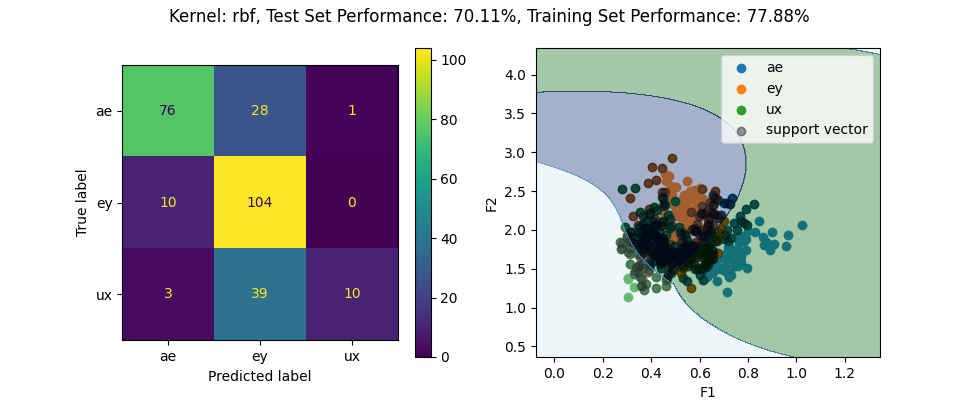

<IPython.core.display.Javascript object>


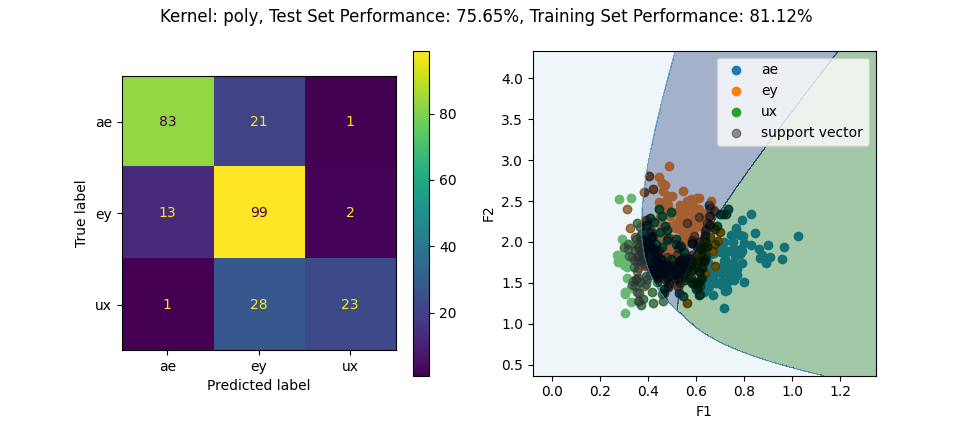

<IPython.core.display.Javascript object>


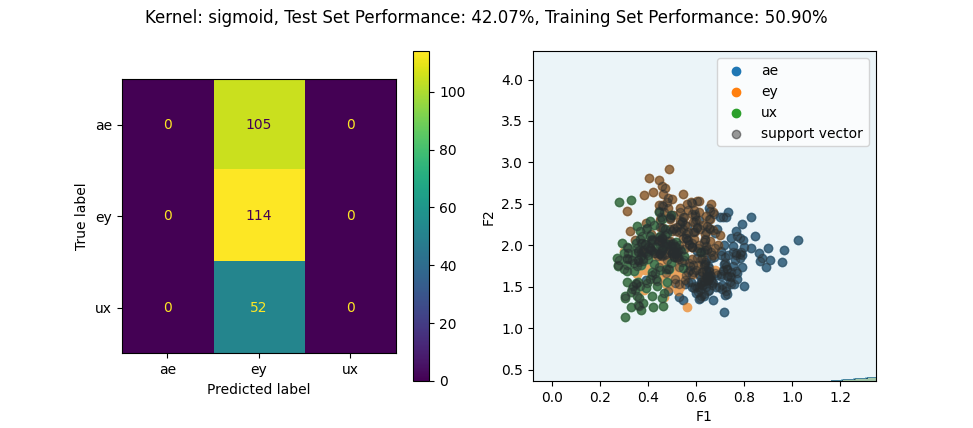

In [125]:
# Fitting
kernels = ['rbf','poly','sigmoid']
clfs = [sklearn.svm.SVC(kernel=kernel,C=1.0) for kernel in kernels]
for clf in clfs:
    clf.fit(feature_vectors,y)

# Prediction
y_test_predictions = [clf.predict(test_vectors) for clf in clfs]
y_train_predictions = [clf.predict(feature_vectors) for clf in clfs]

test_performance = [100*sum(y_pred==y_test_actual)/len(y_pred) for y_pred in y_test_predictions]
train_performance = [100*sum(y_pred==y)/len(y_pred) for y_pred in y_train_predictions]

# Plot
conf_mats = [skm.confusion_matrix(y_test_actual,y_test_predict) for y_test_predict in y_test_predictions]

for index, conf_mat in enumerate(conf_mats):
    fig, axs = plt.subplots(1,2)
    fig.suptitle(
        "Kernel: {kernel_f}, Test Set Performance: {test_f:.2f}%, Training Set Performance: {train_f:.2f}%".format(
            kernel_f=kernels[index],
            test_f=test_performance[index],
            train_f=train_performance[index],
        )
    )
    disp = skm.ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=[height_levels[0],height_levels[1],height_levels[2]],
    )
    disp.plot(ax=axs[0])
    plot_svm_decision_regions(clf=clfs[index],data=train,columns=columns,ax=axs[1])
    plot_support_vectors(clf=clfs[index],data=train,ax=axs[1])

<IPython.core.display.Javascript object>


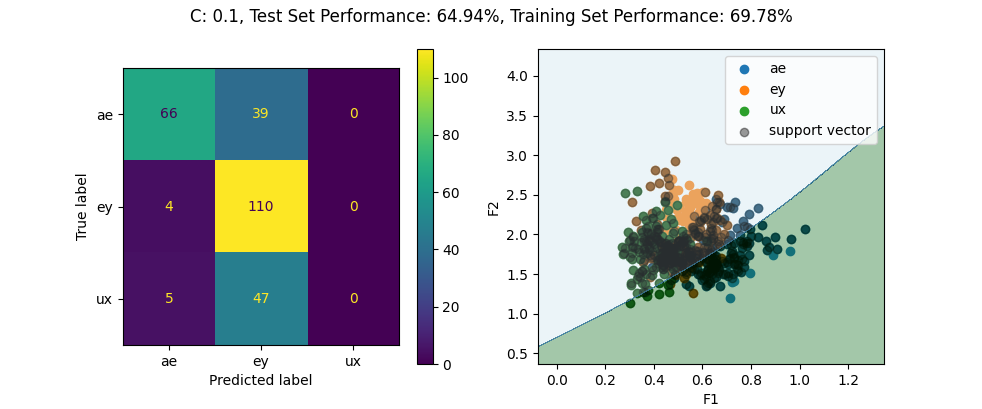

<IPython.core.display.Javascript object>


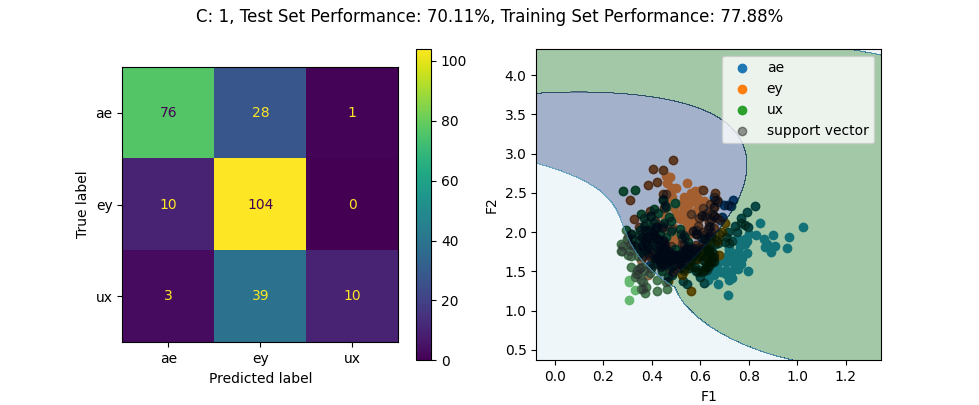

<IPython.core.display.Javascript object>


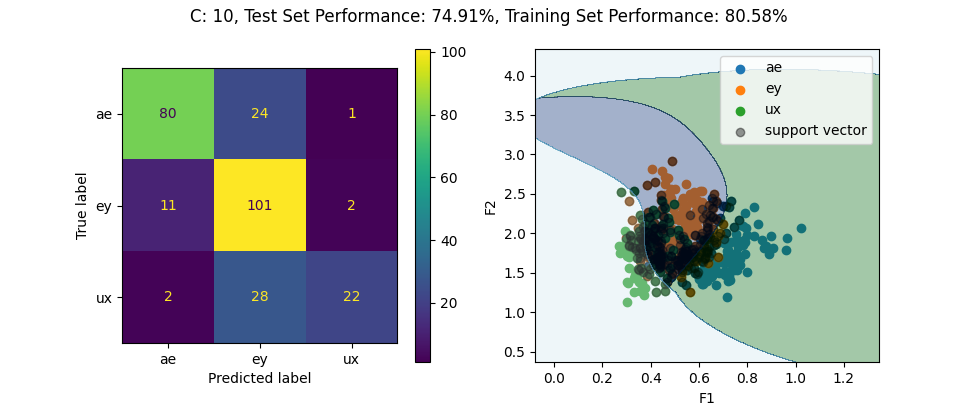

<IPython.core.display.Javascript object>


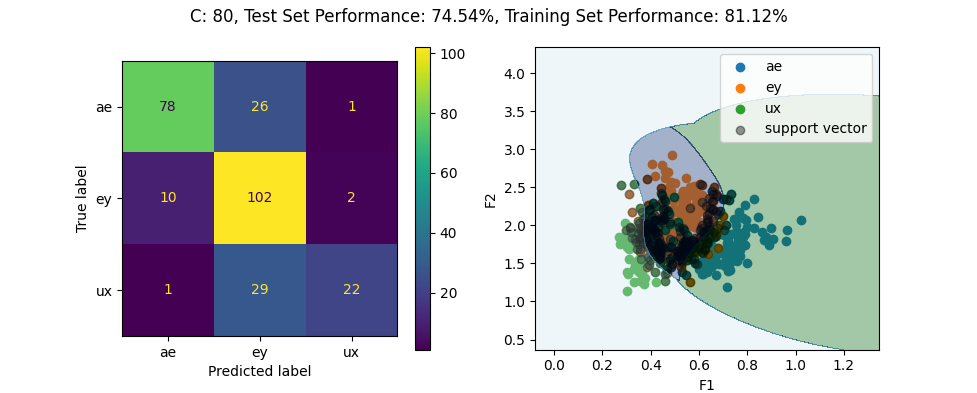

<IPython.core.display.Javascript object>


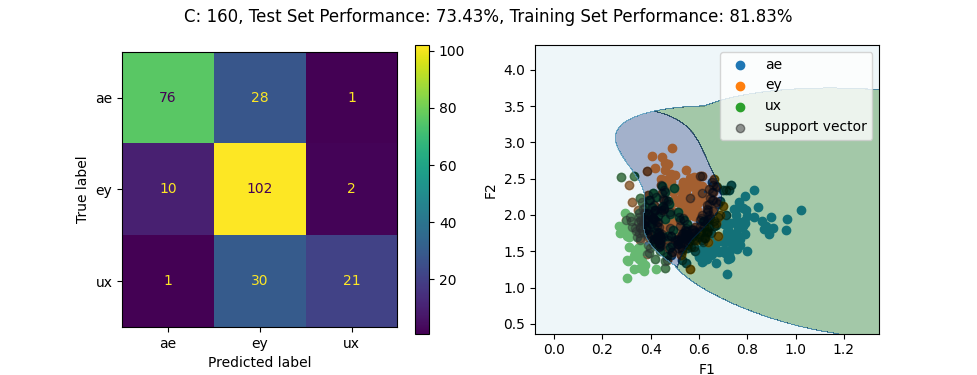

In [128]:
# Fitting
cs = [0.1,1,10,80,160]
clfs = [sklearn.svm.SVC(kernel='rbf',C=c) for c in cs]
for clf in clfs:
    clf.fit(feature_vectors,y)

# Prediction
y_test_predictions = [clf.predict(test_vectors) for clf in clfs]
y_train_predictions = [clf.predict(feature_vectors) for clf in clfs]

test_performance = [100*sum(y_pred==y_test_actual)/len(y_pred) for y_pred in y_test_predictions]
train_performance = [100*sum(y_pred==y)/len(y_pred) for y_pred in y_train_predictions]

# Plot
conf_mats = [skm.confusion_matrix(y_test_actual,y_test_predict) for y_test_predict in y_test_predictions]

for index, conf_mat in enumerate(conf_mats):
    fig, axs = plt.subplots(1,2)
    fig.suptitle(
        "C: {cs_f}, Test Set Performance: {test_f:.2f}%, Training Set Performance: {train_f:.2f}%".format(
            cs_f=cs[index],
            test_f=test_performance[index],
            train_f=train_performance[index],
        )
    )
    disp = skm.ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=[height_levels[0],height_levels[1],height_levels[2]],
    )
    disp.plot(ax=axs[0])
    plot_svm_decision_regions(clf=clfs[index],data=train,columns=columns,ax=axs[1])
    plot_support_vectors(clf=clfs[index],data=train,ax=axs[1])

The training set performance keeps increasing with larger C. The test set performance on the other hand increases up until a certain point. Then it starts to decrease. At this point the model fits the data from the training set specifically and we're in the state of overfitting.